# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy
import torch
from torch.utils.data import Dataset
import pickle
import os
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import torchvision
from torch.utils.data import DataLoader

# to use GPU
device='cpu'
if torch.cuda.is_available():
    device=torch.device("cuda")

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [3]:
# load the data set
with open('train_cifar.pkl','rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']
X = torch.reshape(torch.from_numpy(X),(50000,3,32,32))
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
# print(X.dtype)
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size=0.1)
# X_train = X_train.to(device)
# y_train = torch.from_numpy(y_train).to(device)
# X_test = X_test.to(device)
# y_test = torch.from_numpy(y_test).to(device)

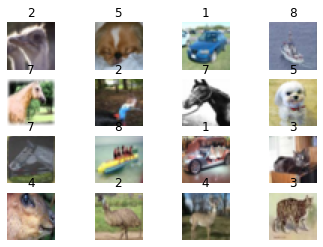

In [4]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1,17):
    pyplot.subplot(4,4,i)
    idx = random.randrange(0,50000)
    image = torch.reshape(X[idx],(32,32,3))
    pyplot.imshow(image)
    pyplot.title(y[idx][0])
    pyplot.axis('off')
pyplot.show()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [5]:
transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
# define your dataset class
class ImageDataSet(Dataset):
    def __init__(self,X,y):
        self.X = transform_norm(X.float())
        self.y=torch.from_numpy(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]





## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [6]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(3,8,3,padding='same') # 8,32,32
        self.bn2 = torch.nn.BatchNorm2d(8)
        self.pool3 = torch.nn.MaxPool2d(2,2) # 8,16,16
        self.conv4 = torch.nn.Conv2d(8,16,3,padding=1) # 16,16,16
        self.bn5 = torch.nn.BatchNorm2d(16)
        self.conv6 = torch.nn.Conv2d(16,16,3,padding=1) # 16,16,16
        self.bn7 = torch.nn.BatchNorm2d(16)
        self.pool8 = torch.nn.MaxPool2d(2,2) # 16,8,8
        self.conv9 = torch.nn.Conv2d(16,16,3,padding=1) # 16,8,8
        self.bn10 = torch.nn.BatchNorm2d(16)
        self.pool11 = torch.nn.MaxPool2d(2,2) # 16,4,4
        self.conv12 = torch.nn.Conv2d(16,32,3,padding=1) # 32,4,4
        self.bn13 = torch.nn.BatchNorm2d(32)
        self.conv14 = torch.nn.Conv2d(32,32,3,padding=1) # 32,4,4
        self.bn15 = torch.nn.BatchNorm2d(32)
        self.pool16 = torch.nn.AvgPool2d(4,4) # 32,1,1
        # 32,1
        self.fc17 = torch.nn.Linear(32,32) # 16,32
        self.bn18 = torch.nn.BatchNorm1d(32)
        self.fc19 = torch.nn.Linear(32,16) # 16,16
        self.bn20 = torch.nn.BatchNorm1d(16)
        self.fc21 = torch.nn.Linear(16,10)
        self.relu = torch.nn.ReLU()
    def forward(self,x):
        x.to(device)
        out = self.relu(self.bn2(self.conv1(x)))
        out = self.pool3(out)
        out = self.relu(self.bn5(self.conv4(out)))
        out = self.relu(self.bn7(self.conv6(out)))
        out = self.pool8(out)
        out = self.relu(self.bn10(self.conv9(out)))
        out = self.pool11(out)
        out = self.relu(self.bn13(self.conv12(out)))
        out = self.relu(self.bn15(self.conv14(out)))
        out = self.pool16(out)
        out = torch.reshape(out,(-1,32))
        out = self.relu(self.bn18(self.fc17(out)))
        out = self.relu(self.bn20(self.fc19(out)))
        out = self.fc21(out)
        out = torch.nn.functional.log_softmax(out,dim=1)
        return out


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [7]:
def train(model, optimizer, criterion, train_loader, display_step=None,n_epochs=100,start_idx=0,start_epoch=0):
    i=start_idx
    model.to(device)
    loss_vals=[]
    epoch_counter=[]
    for epoch in range(start_epoch,n_epochs+start_epoch):    
        loss=0
        for images,labels in train_loader:
            # images.to(device)
            images,labels = torch.autograd.Variable(images).to(device),labels.to(device)
            # labels.to(device)
            labels = torch.reshape(labels,(-1,))
            outputs = model.forward(images)
            loss = criterion(outputs,labels)
            loss.to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if display_step:
                if((i)%display_step==0):
                    print(f'epoch {epoch+1},i={i},loss = {loss.item()}')
            i+=1
        epoch_counter.append(epoch)
        loss_vals.append(loss.item())
    return epoch_counter,loss_vals,i
        

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [8]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [9]:
def predict(model, X_test):
    model.to('cpu')
    X_test_ = X_test.float().reshape(-1,3,32,32)
    scores = model.forward(X_test_)
    np_scores = scores.detach().numpy()
    predictions = np_scores.argmax(axis = 1,keepdims = True)
    return predictions

In [10]:
def accuracy(pred, labels):
    total =0
    for x in range(pred.shape[0]):
        if(pred[x][0] == labels[x][0]):
            total += 1
    return 100*total/pred.shape[0]

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


epoch 1,i=0,loss = 2.384814500808716
epoch 3,i=1000,loss = 1.512094497680664
epoch 6,i=2000,loss = 1.5390238761901855
epoch 9,i=3000,loss = 1.3531831502914429
epoch 12,i=4000,loss = 1.3043304681777954
epoch 15,i=5000,loss = 1.5709788799285889
epoch 18,i=6000,loss = 1.2689591646194458
epoch 20,i=7000,loss = 1.130135416984558
epoch 23,i=8000,loss = 1.307171106338501
epoch 26,i=9000,loss = 1.0794776678085327
epoch 29,i=10000,loss = 0.9732096195220947
epoch 32,i=11000,loss = 1.0420680046081543
epoch 35,i=12000,loss = 1.0904557704925537
epoch 37,i=13000,loss = 1.0094674825668335
epoch 40,i=14000,loss = 1.2507323026657104

Continuing with lower learning rate
epoch 53,i=15000,loss = 0.9033547639846802
epoch 56,i=16000,loss = 0.9577018618583679
epoch 59,i=17000,loss = 0.9775224328041077
epoch 62,i=18000,loss = 0.8554164171218872
epoch 64,i=19000,loss = 1.102609634399414
epoch 67,i=20000,loss = 0.9427295923233032
epoch 70,i=21000,loss = 0.946412980556488
epoch 73,i=22000,loss = 1.06035530567169

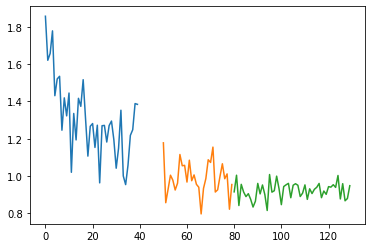

In [11]:
model = Model()
criterion = torch.nn.NLLLoss()
# criterion.to(device)
optimizer = torch.optim.RMSprop(model.parameters())
# print(optimizer.parameters())
# optimizer.to(device)
train_data = ImageDataSet(X_train,y_train)
train_loader = DataLoader(train_data,batch_size = 128, shuffle = True)
# model.to(device)
# train_data.to(device)
# train_loader.to(device)
x_plot,y_plot,i = train(model,optimizer,criterion,train_loader,display_step = 1000,n_epochs=40)
pyplot.plot(x_plot,y_plot)
optimizer2 = torch.optim.Adagrad(model.parameters(),lr=0.001)
print("\nContinuing with lower learning rate")
x_plot1,y_plot1,i = train(model,optimizer2,criterion,train_loader,display_step = 1000, n_epochs = 30,start_idx=i,start_epoch=50)
pyplot.plot(x_plot1,y_plot1)
optimizer3 = torch.optim.Adagrad(model.parameters(),lr=0.0001)
print("\nContinuing with lower learning rate and larger batch size")
train_loader = DataLoader(train_data,batch_size = 512, shuffle = True)
x_plot2,y_plot2,i = train(model,optimizer3,criterion,train_loader,display_step = 1000, n_epochs = 50,start_idx=i,start_epoch=80)
pyplot.plot(x_plot2,y_plot2)
pyplot.show()

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [12]:
predictions = predict(model,X_test)
print(f'Test set Accuracy = {accuracy(predictions,y_test)}%')

Test set Accuracy = 54.1%


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_3.pt``` model-weights file to the repository.

In [13]:
torch.save(model, 'ass_3.pt')

Check if it got saved right!

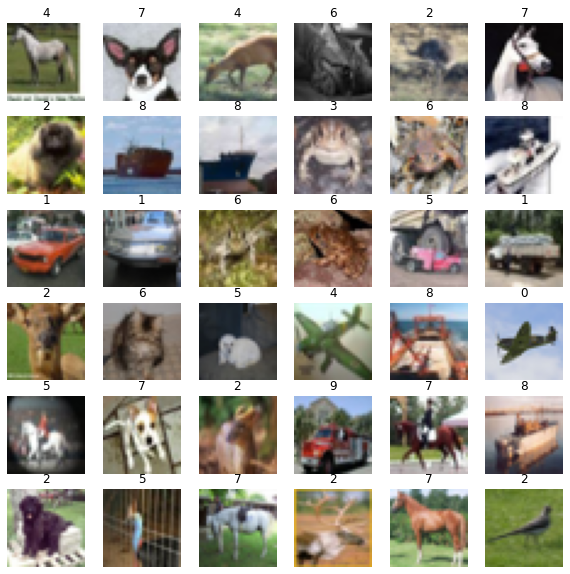

Accuracy for the complete set = 66.242


In [14]:
# load the model, use predict function
final_model = torch.load('ass_3.pt')
with open('train_cifar.pkl','rb') as f:
    data = pickle.load(f)
X = torch.from_numpy(data['X'])
y = data['y']
predictions = predict(model,X)
pyplot.figure(figsize = (10,10))
for i in range(1,37):
    idx = random.randrange(X.shape[0])
    pyplot.subplot(6,6,i)
    pyplot.imshow(X[idx])
    pyplot.axis('off')
    pyplot.title(predictions[idx][0])
pyplot.show()
print(f'Accuracy for the complete set = {accuracy(predictions,y)}')